## *Tools & libraries*

In [5]:
import numpy as np
import pandas as pd
import os
import re
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from keras.layers import Embedding

from keras.models import Sequential
from keras.layers import Dense, Embedding, GRU, LSTM, Bidirectional
from keras.initializers import Constant
from keras.callbacks import ModelCheckpoint
from keras.models import load_model

## *Get the data*

In [6]:
data_1 = pd.read_json("/content/Sarcasm_Headlines_Dataset.json", lines=True)
data_2 = pd.read_json("/content/Sarcasm_Headlines_Dataset_v2.json", lines=True)
data =  pd.concat([data_1, data_2])
data.head()

,article_link,headline,is_sarcastic
0,https://www.huffingtonpost.com/entry/versace-b...,former versace store clerk sues over secret 'b...,0
1,https://www.huffingtonpost.com/entry/roseanne-...,the 'roseanne' revival catches up to our thorn...,0
2,https://local.theonion.com/mom-starting-to-fea...,mom starting to fear son's web series closest ...,1
3,https://politics.theonion.com/boehner-just-wan...,"boehner just wants wife to listen, not come up...",1
4,https://www.huffingtonpost.com/entry/jk-rowlin...,j.k. rowling wishes snape happy birthday in th...,0


## *Clean the data*

In [7]:
def clean_text(text):
    text = text.lower()

    pattern = re.compile('http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\(\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+')
    text = pattern.sub('', text)
    text = " ".join(filter(lambda x:x[0]!='@', text.split()))
    emoji = re.compile("["
                           u"\U0001F600-\U0001FFFF"  # emoticons
                           u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                           u"\U0001F680-\U0001F6FF"  # transport & map symbols
                           u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           u"\U00002702-\U000027B0"
                           u"\U000024C2-\U0001F251"
                           "]+", flags=re.UNICODE)

    text = emoji.sub(r'', text)
    text = text.lower()
    text = re.sub(r"i'm", "i am", text)
    text = re.sub(r"he's", "he is", text)
    text = re.sub(r"she's", "she is", text)
    text = re.sub(r"that's", "that is", text)
    text = re.sub(r"what's", "what is", text)
    text = re.sub(r"where's", "where is", text)
    text = re.sub(r"\'ll", " will", text)
    text = re.sub(r"\'ve", " have", text)
    text = re.sub(r"\'re", " are", text)
    text = re.sub(r"\'d", " would", text)
    text = re.sub(r"\'ve", " have", text)
    text = re.sub(r"won't", "will not", text)
    text = re.sub(r"don't", "do not", text)
    text = re.sub(r"did't", "did not", text)
    text = re.sub(r"can't", "can not", text)
    text = re.sub(r"it's", "it is", text)
    text = re.sub(r"couldn't", "could not", text)
    text = re.sub(r"have't", "have not", text)
    text = re.sub(r"[,.\"\'!@#$%^&*(){}?/;`~:<>+=-]", "", text)
    return text

In [9]:
import nltk
nltk.download('punkt')


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [11]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [12]:
import string
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords

def CleanTokenize(df):
    head_lines = list()
    lines = df["headline"].values.tolist()

    for line in lines:
        line = clean_text(line)
        # tokenize the text
        tokens = word_tokenize(line)
        # remove puntuations
        table = str.maketrans('', '', string.punctuation)
        stripped = [w.translate(table) for w in tokens]
        # remove non alphabetic characters
        words = [word for word in stripped if word.isalpha()]
        stop_words = set(stopwords.words("english"))
        # remove stop words
        words = [w for w in words if not w in stop_words]
        head_lines.append(words)
    return head_lines

head_lines = CleanTokenize(data)
head_lines[0:10]

[['former',
  'versace',
  'store',
  'clerk',
  'sues',
  'secret',
  'black',
  'code',
  'minority',
  'shoppers'],
 ['roseanne',
  'revival',
  'catches',
  'thorny',
  'political',
  'mood',
  'better',
  'worse'],
 ['mom',
  'starting',
  'fear',
  'sons',
  'web',
  'series',
  'closest',
  'thing',
  'grandchild'],
 ['boehner',
  'wants',
  'wife',
  'listen',
  'come',
  'alternative',
  'debtreduction',
  'ideas'],
 ['jk', 'rowling', 'wishes', 'snape', 'happy', 'birthday', 'magical', 'way'],
 ['advancing', 'worlds', 'women'],
 ['fascinating', 'case', 'eating', 'labgrown', 'meat'],
 ['ceo', 'send', 'kids', 'school', 'work', 'company'],
 ['top', 'snake', 'handler', 'leaves', 'sinking', 'huckabee', 'campaign'],
 ['fridays', 'morning', 'email', 'inside', 'trumps', 'presser', 'ages']]

## *Visualize the most occuring words*

(-0.5, 999.5, 499.5, -0.5)

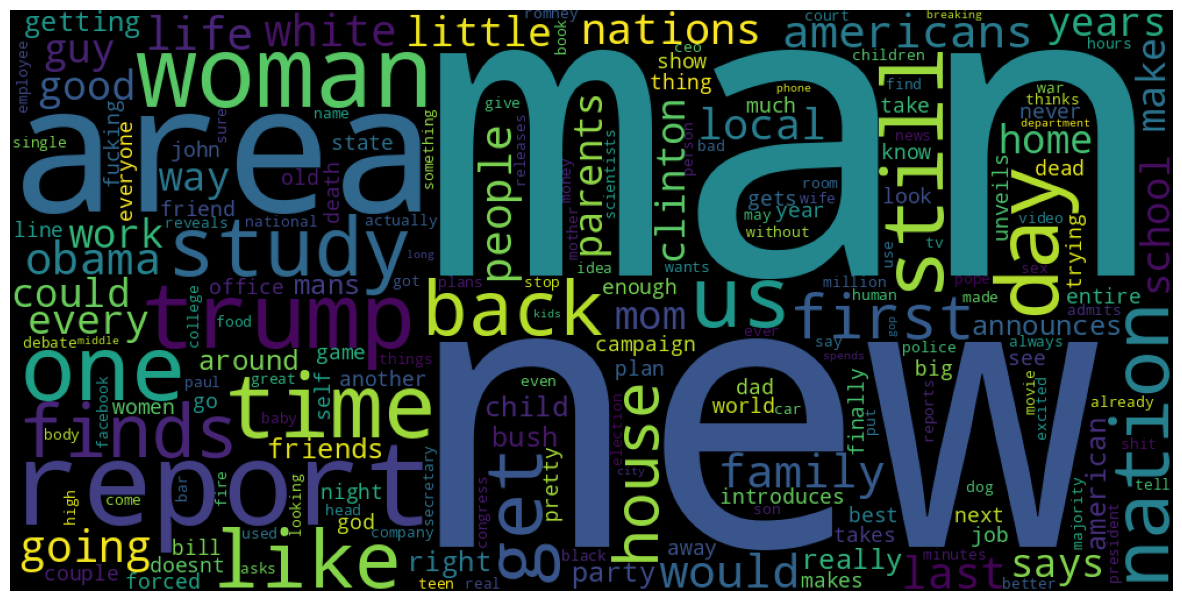

In [13]:
from collections import Counter
from wordcloud import WordCloud, ImageColorGenerator
pos_data = data.loc[data['is_sarcastic'] == 1]
pos_head_lines = CleanTokenize(pos_data)
pos_lines = [j for sub in pos_head_lines for j in sub]
word_could_dict=Counter(pos_lines)

wordcloud = WordCloud(width = 1000, height = 500).generate_from_frequencies(word_could_dict)
plt.figure(figsize=(15,8))
plt.imshow(wordcloud)
plt.axis("off")

## *Train-test split*

In [14]:
validation_split = 0.2
max_length = 25


tokenizer_obj = Tokenizer()
tokenizer_obj.fit_on_texts(head_lines)
sequences = tokenizer_obj.texts_to_sequences(head_lines)

word_index = tokenizer_obj.word_index
print("unique tokens - ",len(word_index))
vocab_size = len(tokenizer_obj.word_index) + 1
print('vocab size -', vocab_size)

lines_pad = pad_sequences(sequences, maxlen=max_length, padding='post')
sentiment =  data['is_sarcastic'].values

indices = np.arange(lines_pad.shape[0])
np.random.shuffle(indices)
lines_pad = lines_pad[indices]
sentiment = sentiment[indices]

num_validation_samples = int(validation_split * lines_pad.shape[0])

X_train_pad = lines_pad[:-num_validation_samples]
y_train = sentiment[:-num_validation_samples]
X_test_pad = lines_pad[-num_validation_samples:]
y_test = sentiment[-num_validation_samples:]

unique tokens -  28657
vocab size - 28658


In [15]:
print('Shape of X_train_pad:', X_train_pad.shape)
print('Shape of y_train:', y_train.shape)

print('Shape of X_test_pad:', X_test_pad.shape)
print('Shape of y_test:', y_test.shape)

Shape of X_train_pad: (44263, 25)
Shape of y_train: (44263,)
Shape of X_test_pad: (11065, 25)
Shape of y_test: (11065,)


## *Load GloVe model*

In [20]:
embeddings_index = {}
embedding_dim = 100

GLOVE_DIR = '/content'

f = open(os.path.join(GLOVE_DIR, 'glove.twitter.27B.100d_wv.txt'), encoding = "utf-8")
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()

print('Found %s word vectors.' % len(embeddings_index))

Found 7363 word vectors.


## *Build the embedding layer*

In [21]:
embedding_matrix = np.zeros((len(word_index) + 1, embedding_dim))
c = 0
for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        c+=1
        embedding_matrix[i] = embedding_vector
print(c)

3050


In [22]:
embedding_layer = Embedding(len(word_index) + 1,
                            embedding_dim,
                            weights=[embedding_matrix],
                            input_length=max_length,
                            trainable=False)

## *Build the RNN*

In [23]:
model = Sequential()
model.add(embedding_layer)
model.add(LSTM(64, dropout=0.2, recurrent_dropout=0.25))
model.add(Dense(1, activation='sigmoid'))

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['acc'])

print('Summary of the built model...')
print(model.summary())

Summary of the built model...
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 25, 100)           2865800   
                                                                 
 lstm (LSTM)                 (None, 64)                42240     
                                                                 
 dense (Dense)               (None, 1)                 65        
                                                                 
Total params: 2908105 (11.09 MB)
Trainable params: 42305 (165.25 KB)
Non-trainable params: 2865800 (10.93 MB)
_________________________________________________________________
None


## *Training*

In [24]:
history = model.fit(X_train_pad, y_train, batch_size=32, epochs=25, validation_data=(X_test_pad, y_test), verbose=2)

Epoch 1/25
1384/1384 - 53s - loss: 0.5928 - acc: 0.6791 - val_loss: 0.5469 - val_acc: 0.7171 - 53s/epoch - 39ms/step
Epoch 2/25
1384/1384 - 48s - loss: 0.5417 - acc: 0.7172 - val_loss: 0.5209 - val_acc: 0.7295 - 48s/epoch - 35ms/step
Epoch 3/25
1384/1384 - 46s - loss: 0.5164 - acc: 0.7375 - val_loss: 0.4960 - val_acc: 0.7485 - 46s/epoch - 33ms/step
Epoch 4/25
1384/1384 - 48s - loss: 0.4976 - acc: 0.7489 - val_loss: 0.4785 - val_acc: 0.7587 - 48s/epoch - 35ms/step
Epoch 5/25
1384/1384 - 46s - loss: 0.4808 - acc: 0.7593 - val_loss: 0.4749 - val_acc: 0.7611 - 46s/epoch - 33ms/step
Epoch 6/25
1384/1384 - 50s - loss: 0.4688 - acc: 0.7646 - val_loss: 0.4671 - val_acc: 0.7656 - 50s/epoch - 36ms/step
Epoch 7/25
1384/1384 - 49s - loss: 0.4551 - acc: 0.7769 - val_loss: 0.4541 - val_acc: 0.7828 - 49s/epoch - 36ms/step
Epoch 8/25
1384/1384 - 47s - loss: 0.4447 - acc: 0.7823 - val_loss: 0.4533 - val_acc: 0.7808 - 47s/epoch - 34ms/step
Epoch 9/25
1384/1384 - 47s - loss: 0.4309 - acc: 0.7906 - val_lo

## *Visualize the learning*

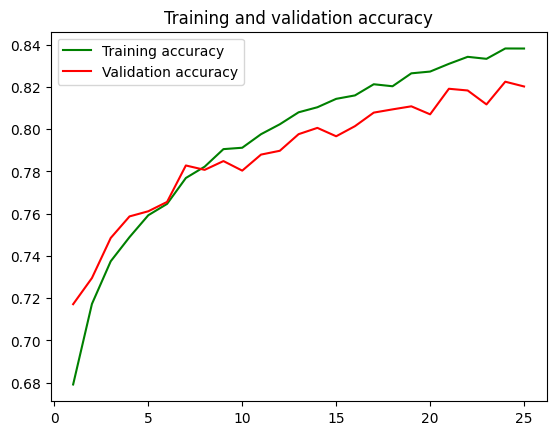

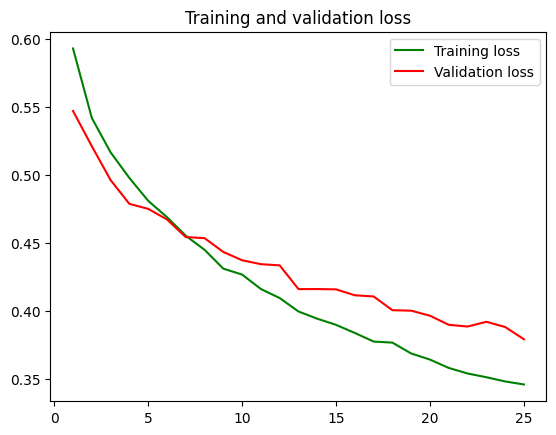

In [25]:
# Plot results
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc)+1)

plt.plot(epochs, acc, 'g', label='Training accuracy')
plt.plot(epochs, val_acc, 'r', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'g', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

<hr>
<h2><i>Can this model detect sarcasms?</i></h2>

In [26]:
def predict_sarcasm(s):
    x_final = pd.DataFrame({"headline":[s]})
    test_lines = CleanTokenize(x_final)
    test_sequences = tokenizer_obj.texts_to_sequences(test_lines)
    test_review_pad = pad_sequences(test_sequences, maxlen=max_length, padding='post')
    pred = model.predict(test_review_pad)
    pred*=100
    if pred[0][0]>=50: return "It's a sarcasm!"
    else: return "It's not a sarcasm."

# ***Save model***

In [58]:
from tensorflow.keras.models import Sequential
# Assuming 'model' is your trained Keras model
model.save("/content/detect sarcasms_eng.h5", "wb")

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


# ***test model***

In [60]:
import numpy as np
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

# Charger le modèle
model = load_model('/content/detect sarcasms_eng.h5')

# Prétraitement de la phrase
phrase = "You just broke my car window. Great job."

# Faire une prédiction

x_final = pd.DataFrame({"headline":[phrase]})
test_lines = CleanTokenize(x_final)
test_sequences = tokenizer_obj.texts_to_sequences(test_lines)
test_review_pad = pad_sequences(test_sequences, maxlen=max_length, padding='post')
pred = model.predict(test_review_pad)
pred*=100
if pred[0][0] >= 50:
    print("It's a sarcasm!")
else:
    print("It's not a sarcasm.")



1/1 [==============================] - 0s 257ms/step
It's a sarcasm!


### *Correct guesses*

In [27]:
predict_sarcasm("I was depressed. He asked me to be happy. I am not depressed anymore.")

1/1 [==============================] - 0s 288ms/step


"It's a sarcasm!"

In [28]:
predict_sarcasm("You just broke my car window. Great job.")

1/1 [==============================] - 0s 22ms/step


"It's a sarcasm!"

In [29]:
predict_sarcasm("You just saved my dog's life. Thanks a million.")

1/1 [==============================] - 0s 41ms/step


"It's not a sarcasm."

In [30]:
predict_sarcasm("I want a million dollars!")

1/1 [==============================] - 0s 34ms/step


"It's not a sarcasm."

In [31]:
predict_sarcasm("I just won a million dollars!")

1/1 [==============================] - 0s 22ms/step


"It's a sarcasm!"

### *Incorrect guesses*

In [33]:
predict_sarcasm("His name is Bob. He is a nice person.")

1/1 [==============================] - 0s 32ms/step


"It's a sarcasm!"

In [32]:
predict_sarcasm("Sarcasm is very easy to detect.")

1/1 [==============================] - 0s 21ms/step


"It's not a sarcasm."